Processing dataset: train_up3.csv
Loading data...


Loading train/test listing IDs...
Loaded 6291 train IDs and 1573 test IDs
Limiting to 4000 random listings for testing
Applying log transformation to price data
Creating calculated features...
Using 2 spatial features, 5 temporal features, 27 amenity features, and 15 price history features
Created 5 test periods:
  Period 1: 2024-01-05 to 2024-01-11
  Period 2: 2024-01-12 to 2024-01-18
  Period 3: 2024-01-19 to 2024-01-25
  Period 4: 2024-01-26 to 2024-02-01
  Period 5: 2024-02-02 to 2024-02-08
Using device: cuda

===== Split 1/5 =====
Training period: 2023-08-07 to 2024-01-04
Testing period: 2024-01-05 to 2024-01-11
Train data: 431205 rows, 3000 unique listings
Test data: 7000 rows, 1000 unique listings

----- Training GNN Model with Reduced LSTM (Split 1) -----
Building enhanced spatial graph with 86488 test listings and 10 nearest neighbors...
Created graph with 1729760 edges
Created enhanced graph with 431205 nodes and 1729760 edges
Train nodes: 344717, Val nodes: 86488
Epoch 1/150

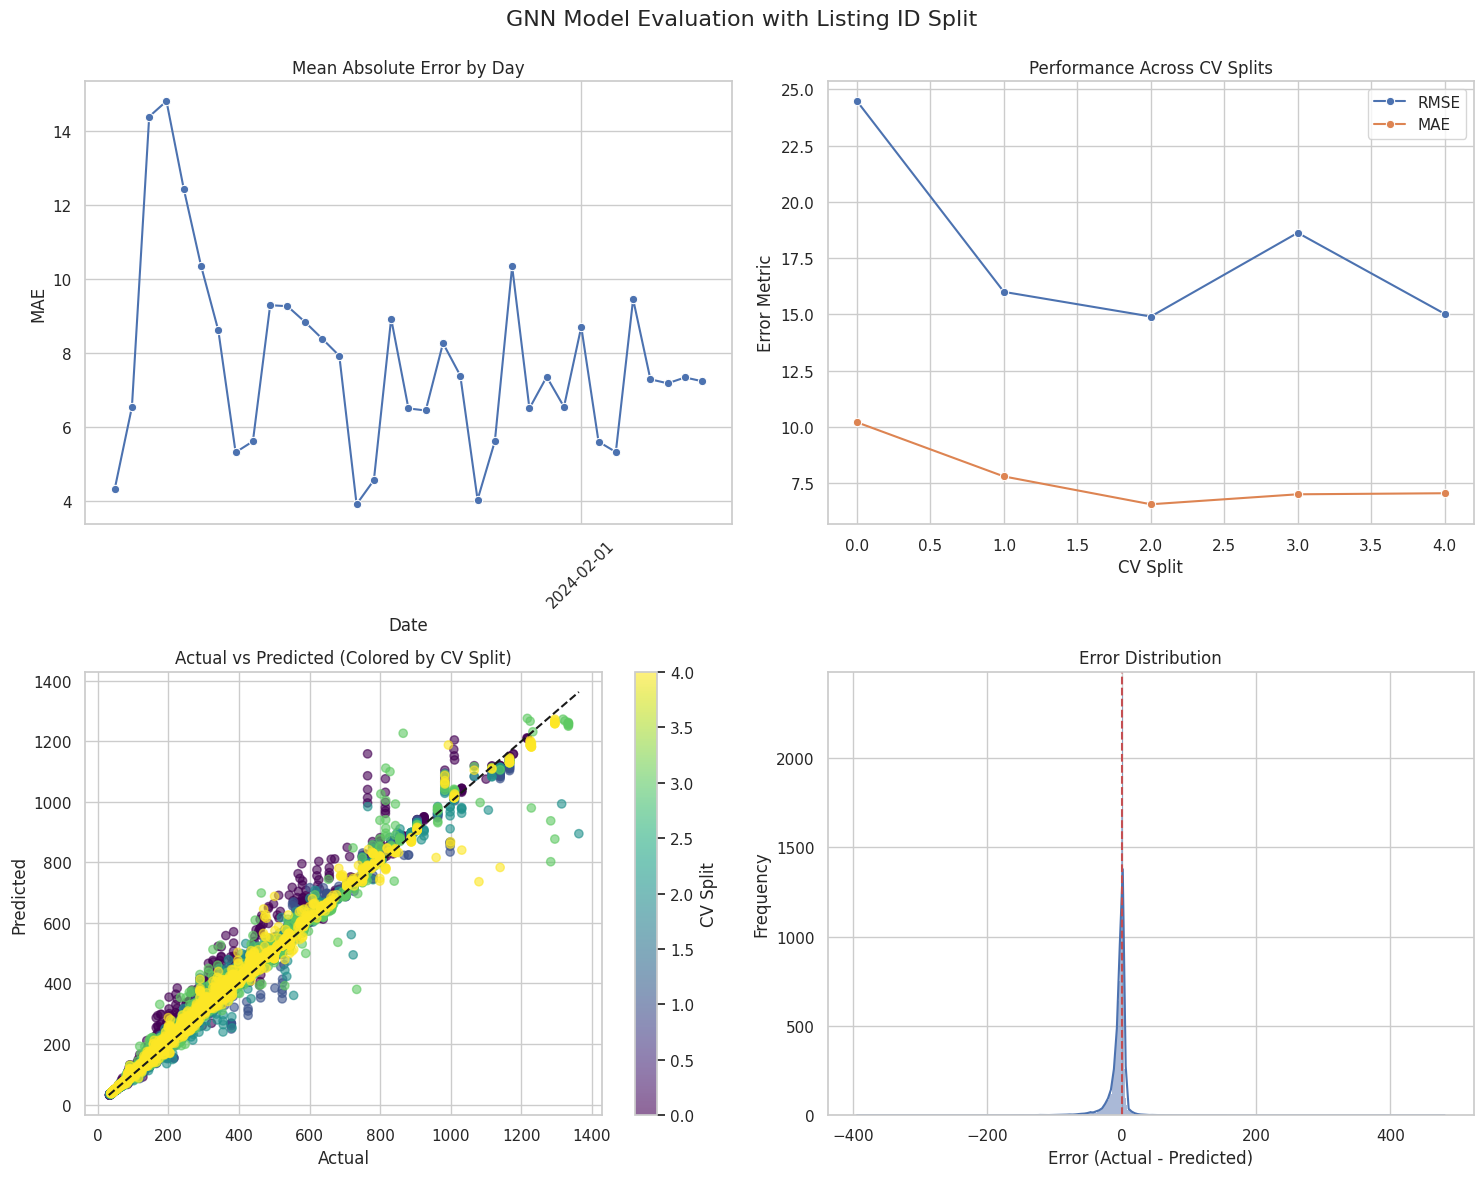

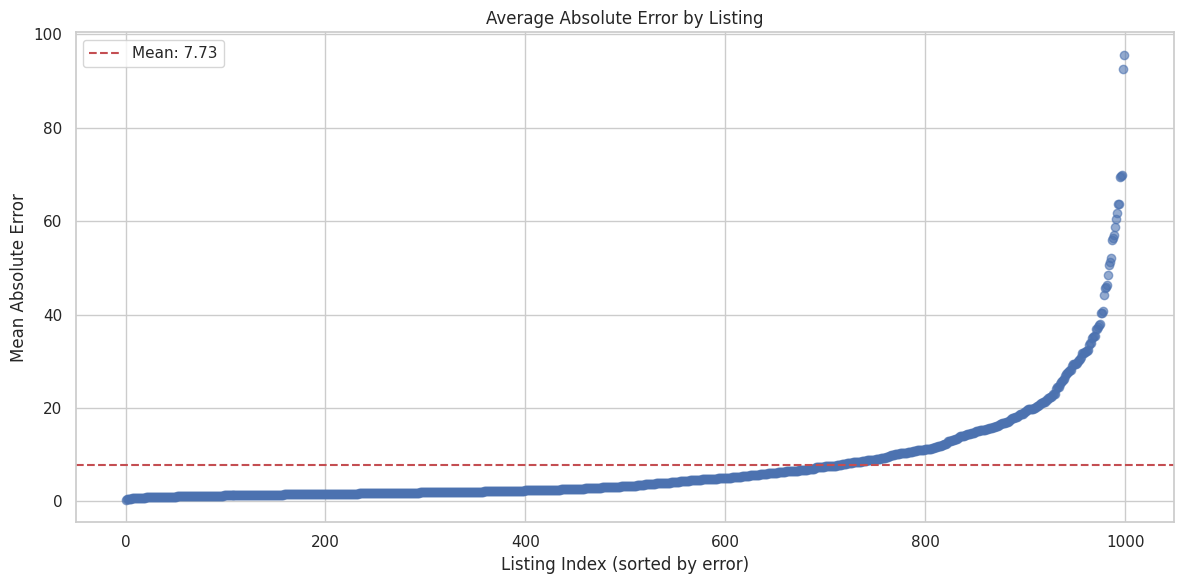

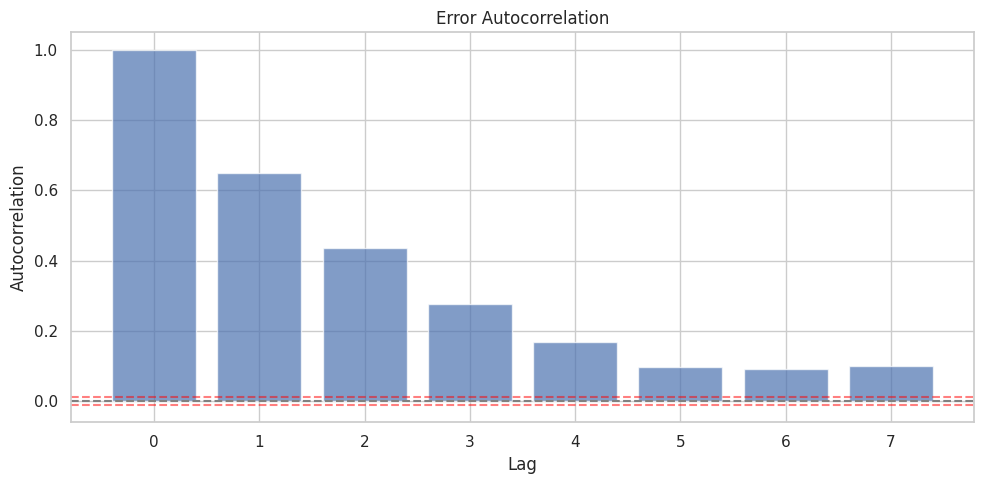

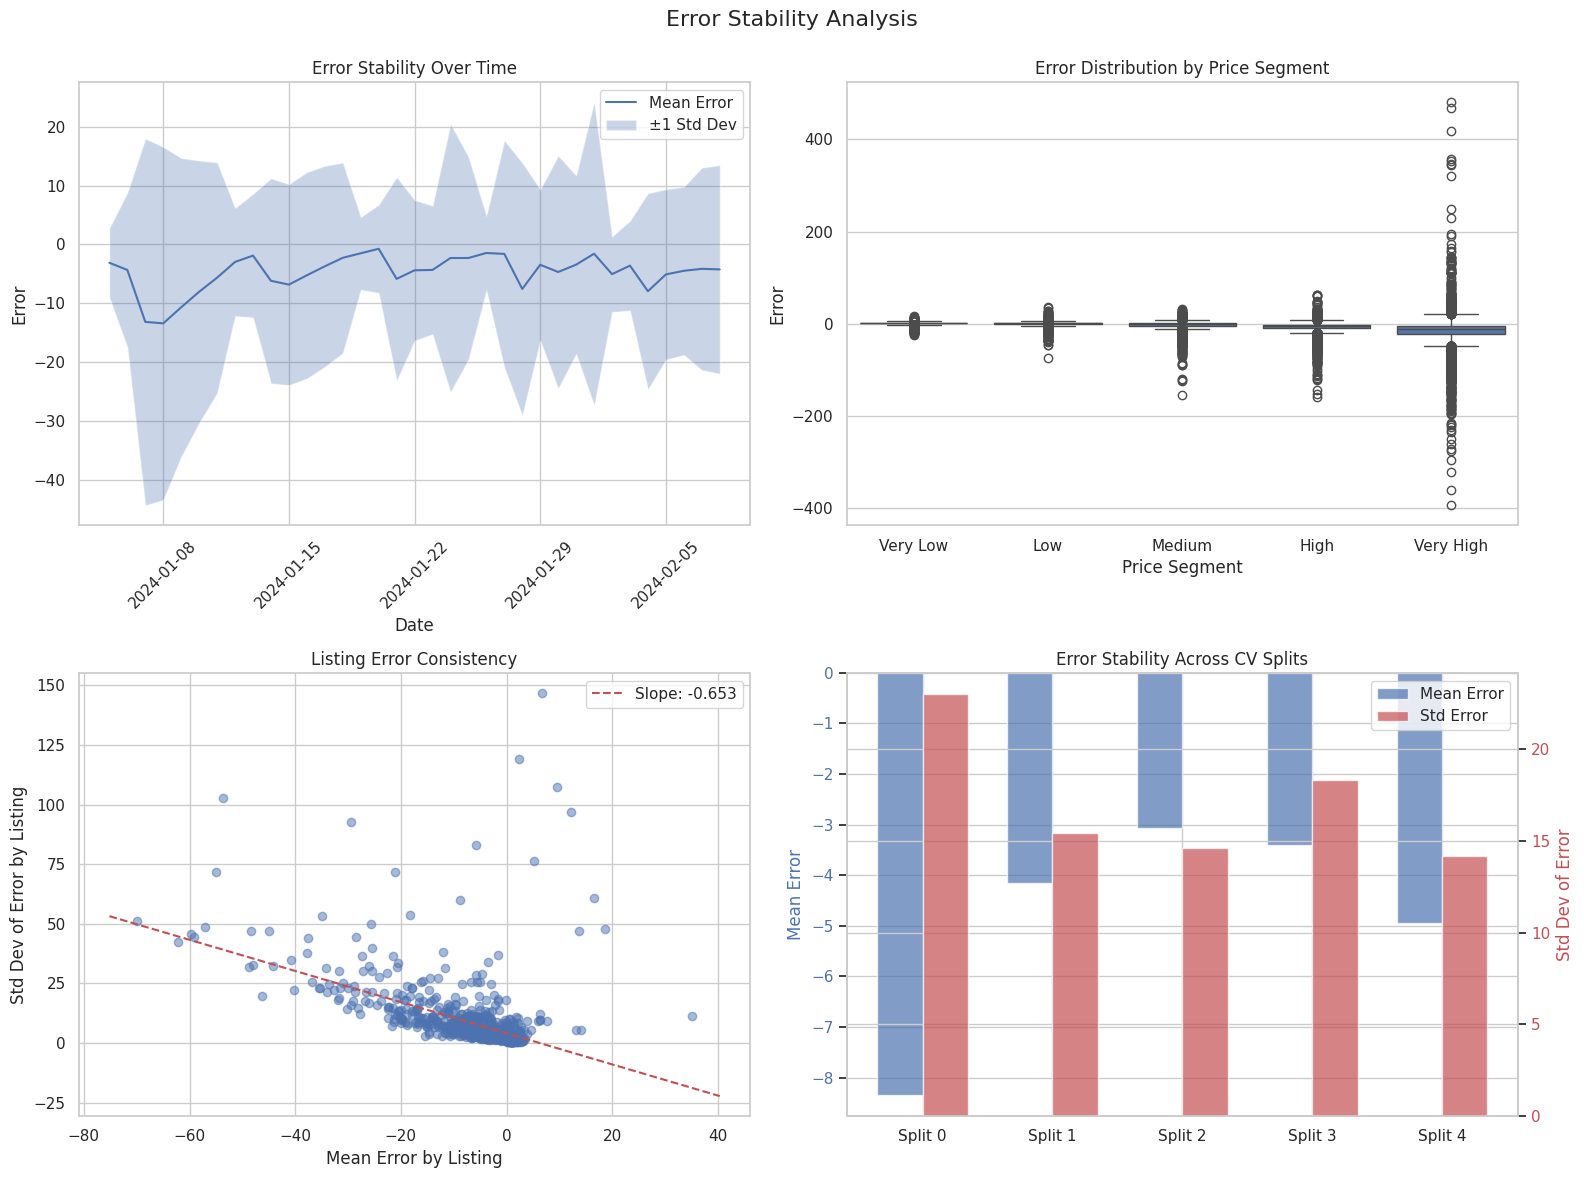

GNN model with reduced LSTM training with rolling window CV completed successfully!


In [3]:
import os
import math
import gc
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, max_error, median_absolute_error
)
from sklearn.neighbors import NearestNeighbors
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')


# Reduced dimensionality TimeSeriesEncoderLSTM
class TimeSeriesEncoderLSTM(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers=1, dropout=0.0, bidirectional=True):
        super(TimeSeriesEncoderLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim  # Reduced internal dimension
        self.output_dim = output_dim  # Final output dimension
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # LSTM layer with reduced hidden dimension
        self.lstm = nn.LSTM(
            input_size=1,  # Single feature per timestep (price)
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Projection layer to map from LSTM output to desired output dimension
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.projection = nn.Linear(lstm_output_dim, output_dim)
        
    def forward(self, x):
        # Reshape input: [batch_size, seq_len] -> [batch_size, seq_len, 1]
        x = x.unsqueeze(-1)
        
        # Pass through LSTM
        output, (hidden, _) = self.lstm(x)
        
        if self.bidirectional:
            # Concatenate the final hidden states from both directions
            hidden_forward = hidden[-2, :, :]
            hidden_backward = hidden[-1, :, :]
            combined = torch.cat((hidden_forward, hidden_backward), dim=1)
        else:
            # Use only the final hidden state
            combined = hidden[-1, :, :]
            
        # Project to output dimension
        projected = self.projection(combined)
        return projected

# Price transformation function
def apply_price_transformation(train_data, inverse=False):
    """
    Apply log transformation to price data or inverse the transformation
    """
    df = train_data.copy()
    
    if not inverse:
        # Apply log transformation
        print("Applying log transformation to price data")
        df['original_price'] = df['price']  # Store original price
        df['price'] = np.log1p(df['price'])  # log1p to handle zero values
    else:
        # Inverse transform
        print("Inverting log transformation for predictions")
        df['price'] = np.expm1(df['price'])  # expm1 is the inverse of log1p
    
    return df

# Create calculated features
def create_calculated_features(df):
    """
    Adapt calculated features to work with provided dataset columns
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Bedroom ratio
    if 'bedrooms' in df_copy.columns and 'accommodates' in df_copy.columns:
        df_copy['bedroom_ratio'] = df_copy['bedrooms'] / df_copy['accommodates'].clip(lower=1)
    
    # Count amenities
    amenity_columns = df_copy.filter(like='has_').columns
    if len(amenity_columns) > 0:
        df_copy['amenity_count'] = df_copy[amenity_columns].sum(axis=1)
    
    # Luxury score - use specific amenities from your dataset
    luxury_amenities = ['has_hot_water', 'has_hair_dryer', 'has_dedicated_workspace', 
                         'has_tv', 'has_wifi', 'has_shampoo']
    available_luxury = [col for col in luxury_amenities if col in df_copy.columns]
    
    if available_luxury:
        df_copy['luxury_score'] = df_copy[available_luxury].sum(axis=1) / len(available_luxury)
    else:
        df_copy['luxury_score'] = 0
    
    # Essential score - basic amenities that are essential
    essential_amenities = ['has_essentials', 'has_bed_linens', 'has_kitchen', 
                           'has_smoke_alarm', 'has_heating']
    available_essential = [col for col in essential_amenities if col in df_copy.columns]
    
    if available_essential:
        df_copy['essential_score'] = df_copy[available_essential].sum(axis=1) / len(available_essential)
    else:
        df_copy['essential_score'] = 0
    
    # Price volatility features based on rolling statistics
    if all(col in df_copy.columns for col in ['rolling_max_7d', 'rolling_min_7d']):
        df_copy['price_range_7d'] = df_copy['rolling_max_7d'] - df_copy['rolling_min_7d']
    
    if all(col in df_copy.columns for col in ['rolling_max_14d', 'rolling_min_14d']):
        df_copy['price_range_14d'] = df_copy['rolling_max_14d'] - df_copy['rolling_min_14d']
    
    if all(col in df_copy.columns for col in ['rolling_max_30d', 'rolling_min_30d']):
        df_copy['price_range_30d'] = df_copy['rolling_max_30d'] - df_copy['rolling_min_30d']
    
    # Fill any NaN values that might have been created
    numeric_cols = df_copy.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if df_copy[col].isnull().any():
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    
    return df_copy

# Build enhanced spatial graph for GNN
def build_enhanced_spatial_graph(train_data, test_data, k=10, feature_weight=0.3):
    """
    Build a graph with edge weights based on both geographic and feature similarity
    """
    # Extract coordinates
    train_coords = train_data[['latitude', 'longitude']].values
    test_coords = test_data[['latitude', 'longitude']].values
    
    print(f"Building enhanced spatial graph with {len(test_coords)} test listings and {k} nearest neighbors...")
    
    # Extract and normalize key features for similarity calculation
    features = ['accommodates', 'bedrooms', 'bathrooms']
    available_features = [f for f in features if f in train_data.columns]
    
    if available_features:
        scaler = StandardScaler()
        train_features = scaler.fit_transform(train_data[available_features].fillna(0))
        test_features = scaler.transform(test_data[available_features].fillna(0))
    else:
        # Fallback if no features are available
        print("Warning: No property features available for similarity calculation")
        train_features = np.ones((len(train_coords), 1))
        test_features = np.ones((len(test_coords), 1))
    
    # Find k nearest neighbors for each test listing
    nn = NearestNeighbors(n_neighbors=min(k, len(train_coords)))
    nn.fit(train_coords)
    distances, indices = nn.kneighbors(test_coords)
    
    # Create edge indices and attributes
    edge_index = []
    edge_attr = []
    
    for test_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(indices, distances)):
        test_feat = test_features[test_idx]
        
        for train_idx, distance in zip(neighbor_indices, neighbor_distances):
            # Calculate feature similarity (cosine similarity)
            train_feat = train_features[train_idx]
            feat_norm_product = np.linalg.norm(test_feat) * np.linalg.norm(train_feat)
            
            if feat_norm_product > 1e-8:  # Avoid division by zero
                feat_sim = np.dot(test_feat, train_feat) / feat_norm_product
            else:
                feat_sim = 0.0
            
            # Normalize distance for better numerical stability
            geo_weight = 1.0 / (distance + 1e-6)
            
            # Combined weight: (1-α) * geo_weight + α * feature_weight
            combined_weight = (1 - feature_weight) * geo_weight + feature_weight * max(0, feat_sim)
            
            # Add edge from test listing to train listing
            edge_index.append([test_idx + len(train_data), train_idx])
            edge_attr.append([combined_weight])
            
            # Add reverse edge
            edge_index.append([train_idx, test_idx + len(train_data)])
            edge_attr.append([combined_weight])
    
    # Add edges between training listings (optional, for smaller datasets)
    if len(train_coords) <= 5000:
        train_nn = NearestNeighbors(n_neighbors=min(5, len(train_coords) - 1))
        train_nn.fit(train_coords)
        train_distances, train_indices = train_nn.kneighbors(train_coords)
        
        for train_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(train_indices, train_distances)):
            for neighbor_idx, distance in zip(neighbor_indices, neighbor_distances):
                if train_idx != neighbor_idx:  # Skip self-loops
                    # Calculate feature similarity
                    train_feat_i = train_features[train_idx]
                    train_feat_j = train_features[neighbor_idx]
                    
                    feat_norm_product = np.linalg.norm(train_feat_i) * np.linalg.norm(train_feat_j)
                    if feat_norm_product > 1e-8:
                        feat_sim = np.dot(train_feat_i, train_feat_j) / feat_norm_product
                    else:
                        feat_sim = 0.0
                    
                    geo_weight = 1.0 / (distance + 1e-6)
                    combined_weight = (1 - feature_weight) * geo_weight + feature_weight * max(0, feat_sim)
                    
                    edge_index.append([train_idx, neighbor_idx])
                    edge_attr.append([combined_weight])
    
    # Convert to tensors with explicit dtype
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float32)
    
    print(f"Created graph with {edge_index_tensor.shape[1]} edges")
    
    return edge_index_tensor, edge_attr_tensor

def create_daily_price_history(df, seq_length=30):
    """
    Create raw price history sequences for each listing
    """
    # Create a copy of the dataframe with reset index
    result_df = df.copy().reset_index(drop=True)
    
    # Get all unique listings
    listings = result_df['listing_id'].unique()
    
    # For each listing
    for listing_id in listings:
        # Get all dates for this listing, sorted
        listing_data = result_df[result_df['listing_id'] == listing_id].sort_values('date')
        
        # For each row in this listing's data - use internal index instead of original DataFrame index
        for idx, (_, row) in enumerate(listing_data.iterrows()):
            current_date = row['date']
            
            # Get previous dates data for this listing
            previous_dates = listing_data[listing_data['date'] < current_date].sort_values('date', ascending=False).head(seq_length)
            
            # Find the corresponding row index in result_df that matches this row
            current_idx = listing_data.index[idx]
            
            # Create sequence features - ONLY the raw price
            for j, prev_row in enumerate(previous_dates.iterrows()):
                day_num = j + 1
                prev_row_data = prev_row[1]  # Get the data from the tuple
                
                # Just store the raw price for each previous day
                result_df.loc[current_idx, f'price_day_{day_num}'] = prev_row_data['price']
            
            # Fill missing days with the last known value or current price
            for day in range(1, seq_length + 1):
                col_name = f'price_day_{day}'
                if col_name not in result_df.columns or pd.isnull(result_df.loc[current_idx, col_name]):
                    # Use the last available price, or current price if none available
                    if previous_dates.empty:
                        result_df.loc[current_idx, col_name] = row['price']
                    else:
                        result_df.loc[current_idx, col_name] = previous_dates.iloc[-1]['price'] if len(previous_dates) > 0 else row['price']
    
    # Create the list of generated features - only price_day_X columns
    sequence_features = [f'price_day_{day}' for day in range(1, seq_length + 1)]
    
    return result_df, sequence_features

# Enhanced GNN model with reduced LSTM dimension
class EnhancedSpatioTemporalGNN(nn.Module):
    def __init__(self, 
             spatial_features_dim,
             temporal_features_dim,
             amenity_features_dim,
             price_history_features_dim,
             price_history_seq_len=30,  
             hidden_dim=64,
             lstm_hidden_dim=32,  # Reduced LSTM hidden dimension
             lstm_layers=1,
             lstm_bidirectional=True,
             dropout=0.3,
             heads=4,
             edge_dim=1):
        super(EnhancedSpatioTemporalGNN, self).__init__()
        
        # Store sequence length as instance attribute
        self.seq_len = price_history_seq_len
        self.use_lstm = price_history_seq_len > 1
        
        # For multi-head attention, ensure hidden_dim is divisible by heads
        self.h_dim = hidden_dim
        self.heads = heads
        self.head_dim = hidden_dim // heads
        
        # Important: Make sure the output dimension is consistent
        gat_out_dim = self.head_dim * heads  # This ensures exact dimensions
        
        # Replace GCN with GAT for better spatial relationship modeling
        self.gat1 = GATv2Conv(spatial_features_dim, self.head_dim, heads=heads, edge_dim=edge_dim)
        self.gat2 = GATv2Conv(gat_out_dim, self.head_dim, heads=heads, edge_dim=edge_dim)
        
        # Add batch normalization for more stable training
        self.bn1 = nn.BatchNorm1d(gat_out_dim)
        self.bn2 = nn.BatchNorm1d(gat_out_dim)
        
        # Enhanced temporal processing
        self.temporal_layer1 = nn.Linear(temporal_features_dim, hidden_dim)
        self.temporal_bn1 = nn.BatchNorm1d(hidden_dim)
        self.temporal_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.temporal_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Enhanced amenity processing with residual connection
        self.amenity_layer1 = nn.Linear(amenity_features_dim, hidden_dim)
        self.amenity_bn1 = nn.BatchNorm1d(hidden_dim)
        self.amenity_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.amenity_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Always create fallback linear layers for price history
        self.price_history_layer1 = nn.Linear(price_history_features_dim, hidden_dim)
        self.price_history_bn1 = nn.BatchNorm1d(hidden_dim)
        self.price_history_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.price_history_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # New: LSTM for price history encoding with reduced dimensions
        self.use_lstm = price_history_seq_len > 1
        
        if self.use_lstm:
            # Use reduced LSTM hidden dimension but project to common hidden_dim
            self.price_history_lstm = TimeSeriesEncoderLSTM(
                hidden_dim=lstm_hidden_dim,  # Reduced internal LSTM dimension
                output_dim=hidden_dim,       # Project back to common hidden_dim
                num_layers=lstm_layers,
                dropout=dropout,
                bidirectional=lstm_bidirectional
            )
            self.lstm_bn = nn.BatchNorm1d(hidden_dim)
        
        # Feature fusion mechanism - updated for 4 feature types
        self.fusion_weights = nn.Parameter(torch.ones(4, hidden_dim))
        self.fusion_bias = nn.Parameter(torch.zeros(hidden_dim))
        
        # Final prediction layers with residual connections
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc1_bn = nn.BatchNorm1d(hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2_bn = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.dropout_heavy = nn.Dropout(dropout + 0.1)
        
        # Optional dimension adjustment if needed
        self.dim_adjust = None
        if gat_out_dim != hidden_dim:
            self.dim_adjust = nn.Linear(gat_out_dim, hidden_dim)
    
    def forward(self, data):
        # Unpack the PyG data object
        x, edge_index, edge_attr, temporal_x, amenity_x, price_history_x = (
            data.x, data.edge_index, data.edge_attr, data.temporal_x, 
            data.amenity_x, data.price_history_x
        )
        
        # First GAT layer with batch normalization and residual
        spatial_features = self.gat1(x, edge_index, edge_attr=edge_attr)
        spatial_features = F.elu(spatial_features)
        spatial_features = self.bn1(spatial_features)
        spatial_features = self.dropout(spatial_features)
        
        # Second GAT layer
        spatial_features_res = spatial_features
        spatial_features = self.gat2(spatial_features, edge_index, edge_attr=edge_attr)
        spatial_features = self.bn2(spatial_features)
        
        # Add residual connection if dimensions match
        if spatial_features.shape == spatial_features_res.shape:
            spatial_features = spatial_features + spatial_features_res
        
        # Apply dimension adjustment if needed
        if self.dim_adjust is not None:
            spatial_features = self.dim_adjust(spatial_features)
        
        # Process temporal features with enhanced layers
        temporal_features = F.elu(self.temporal_layer1(temporal_x))
        temporal_features = self.temporal_bn1(temporal_features)
        temporal_features = self.dropout(temporal_features)
        temporal_features_res = temporal_features
        temporal_features = F.elu(self.temporal_layer2(temporal_features))
        temporal_features = self.temporal_bn2(temporal_features)
        temporal_features = temporal_features + temporal_features_res  # Residual connection
        
        # Process amenity features with residual connection
        amenity_features = F.elu(self.amenity_layer1(amenity_x))
        amenity_features = self.amenity_bn1(amenity_features)
        amenity_features = self.dropout(amenity_features)
        amenity_features_res = amenity_features
        amenity_features = F.elu(self.amenity_layer2(amenity_features))
        amenity_features = self.amenity_bn2(amenity_features)
        amenity_features = amenity_features + amenity_features_res  # Residual connection
        
        # Process price history features
        # Get batch size
        batch_size = price_history_x.shape[0]
        
        # Decision path for processing price history
        if self.use_lstm:
            try:
                # For raw time series, reshape directly to [batch_size, seq_len]
                # Assuming the price_history_x contains seq_len sequential prices
                price_history_seq = price_history_x.reshape(batch_size, self.seq_len)
                
                # Pass through LSTM encoder with reduced dimension
                price_history_features = self.price_history_lstm(price_history_seq)
                price_history_features = self.lstm_bn(price_history_features)
            except Exception as e:
                print(f"Error in LSTM processing: {e}. Falling back to linear layers.")
                # Fallback to linear layers
                price_history_features = F.elu(self.price_history_layer1(price_history_x))
                price_history_features = self.price_history_bn1(price_history_features)
                price_history_features = self.dropout(price_history_features)
                price_history_res = price_history_features
                price_history_features = F.elu(self.price_history_layer2(price_history_features))
                price_history_features = self.price_history_bn2(price_history_features)
                price_history_features = price_history_features + price_history_res  # Residual connection
        else:
            # Use linear layers
            price_history_features = F.elu(self.price_history_layer1(price_history_x))
            price_history_features = self.price_history_bn1(price_history_features)
            price_history_features = self.dropout(price_history_features)
            price_history_res = price_history_features
            price_history_features = F.elu(self.price_history_layer2(price_history_features))
            price_history_features = self.price_history_bn2(price_history_features)
            price_history_features = price_history_features + price_history_res  # Residual connection
        
        # Dynamic feature fusion with learned weights
        normalized_weights = F.softmax(self.fusion_weights, dim=0)
        
        # Apply weights to each feature type - now including price history
        fused_features = (
            spatial_features * normalized_weights[0] +
            temporal_features * normalized_weights[1] +
            amenity_features * normalized_weights[2] +
            price_history_features * normalized_weights[3] +
            self.fusion_bias
        )
        
        # Final prediction with residual connections
        out = F.elu(self.fc1(fused_features))
        out = self.fc1_bn(out)
        out = self.dropout(out)
        
        out = F.elu(self.fc2(out))
        out = self.fc2_bn(out)
        out = self.dropout_heavy(out)
        
        price_prediction = self.fc3(out)
        
        return price_prediction

# Function to prepare graph data
def prepare_enhanced_graph(train_data, val_data, spatial_features, temporal_features, 
                          amenity_features, price_history_features, spatial_scaler, 
                          temporal_scaler, amenity_scaler, price_history_scaler, target_scaler,
                          device, k=10, feature_weight=0.3, seq_len=30):
    """
    Prepare a combined graph with both train and validation listings using enhanced features
    with sequential price history data for LSTM
    """
    # Scale the spatial features
    X_train_spatial = spatial_scaler.transform(train_data[spatial_features]).astype(np.float32)
    X_val_spatial = spatial_scaler.transform(val_data[spatial_features]).astype(np.float32)
    
    # Scale the temporal features
    X_train_temporal = temporal_scaler.transform(train_data[temporal_features]).astype(np.float32)
    X_val_temporal = temporal_scaler.transform(val_data[temporal_features]).astype(np.float32)
    
    # Scale the amenity features
    X_train_amenity = amenity_scaler.transform(train_data[amenity_features]).astype(np.float32)
    X_val_amenity = amenity_scaler.transform(val_data[amenity_features]).astype(np.float32)
    
    # Transform the target variable
    y_train = target_scaler.transform(train_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    # Special handling for price history to create raw time series
    X_train_price_history = np.zeros((len(train_data), seq_len), dtype=np.float32)
    # Fix: Use enumerate instead of iterrows to get sequential indices
    for idx, (_, row) in enumerate(train_data.iterrows()):
        for day in range(1, seq_len + 1):
            col_name = f'price_day_{day}'
            if col_name in train_data.columns and not pd.isnull(row[col_name]):
                X_train_price_history[idx, day-1] = row[col_name]
            else:
                # Fill with last known value or the current price
                X_train_price_history[idx, day-1] = row['price']
    
    # Do the same for validation data
    X_val_price_history = np.zeros((len(val_data), seq_len), dtype=np.float32)
    # Fix: Use enumerate for validation data too
    for idx, (_, row) in enumerate(val_data.iterrows()):
        for day in range(1, seq_len + 1):
            col_name = f'price_day_{day}'
            if col_name in val_data.columns and not pd.isnull(row[col_name]):
                X_val_price_history[idx, day-1] = row[col_name]
            else:
                X_val_price_history[idx, day-1] = row['price']
    
    # Scale the time series data
    X_train_price_history = price_history_scaler.fit_transform(X_train_price_history)
    X_val_price_history = price_history_scaler.transform(X_val_price_history)
    
    y_val = target_scaler.transform(val_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    # Combine train and val features
    X_combined_spatial = np.vstack([X_train_spatial, X_val_spatial])
    X_combined_temporal = np.vstack([X_train_temporal, X_val_temporal])
    X_combined_amenity = np.vstack([X_train_amenity, X_val_amenity])
    X_combined_price_history = np.vstack([X_train_price_history, X_val_price_history])
    
    # Create combined y with placeholder values for validation
    y_combined = np.zeros(len(X_combined_spatial), dtype=np.float32)
    y_combined[:len(y_train)] = y_train
    
    # Build enhanced spatial graph with feature similarity
    edge_index, edge_attr = build_enhanced_spatial_graph(
        train_data[['latitude', 'longitude'] + [f for f in ['accommodates', 'bedrooms', 'bathrooms'] if f in train_data.columns]], 
        val_data[['latitude', 'longitude'] + [f for f in ['accommodates', 'bedrooms', 'bathrooms'] if f in val_data.columns]], 
        k=k,
        feature_weight=feature_weight
    )
    
    # Create PyG data object with explicit float32 tensors
    data = Data(
        x=torch.FloatTensor(X_combined_spatial).to(device),
        edge_index=edge_index.to(device),
        edge_attr=edge_attr.to(device),
        temporal_x=torch.FloatTensor(X_combined_temporal).to(device),
        amenity_x=torch.FloatTensor(X_combined_amenity).to(device),
        price_history_x=torch.FloatTensor(X_combined_price_history).to(device),
        y=torch.FloatTensor(y_combined.reshape(-1, 1)).to(device),
        train_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool).to(device),
        val_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool).to(device),
        val_y=torch.FloatTensor(y_val.reshape(-1, 1)).to(device),
    )
    
    # Store sequence length for LSTM
    data.seq_len = seq_len
    
    # Set masks after creation
    data.train_mask[:len(X_train_spatial)] = True
    data.val_mask[len(X_train_spatial):] = True
    data.val_indices = torch.nonzero(data.val_mask).squeeze().to(device)
    
    print(f"Created enhanced graph with {len(X_combined_spatial)} nodes and {edge_index.shape[1]} edges")
    print(f"Train nodes: {data.train_mask.sum().item()}, Val nodes: {data.val_mask.sum().item()}")
    
    return data

# Train GNN model function
def train_gnn_model(train_data, val_data, spatial_features, temporal_features, amenity_features, 
                   price_history_features, hidden_dim=64, lstm_hidden_dim=32, lstm_layers=1, 
                   price_history_seq_len=30, epochs=50, lr=0.001, device='cuda', batch_size=64):
    """
    Train GNN model with log-transformed prices and price history features using LSTM with reduced dimension
    """
    # Initialize scalers
    spatial_scaler = StandardScaler()
    temporal_scaler = StandardScaler()
    amenity_scaler = StandardScaler()
    price_history_scaler = StandardScaler()
    target_scaler = StandardScaler()

    # Check if we have price_history_features
    if not price_history_features or len(price_history_features) == 0:
        print("Warning: No price history features provided. Creating dummy feature.")
        price_history_features = ['dummy_price_history']
        train_data['dummy_price_history'] = 1.0
        val_data['dummy_price_history'] = 1.0

    # Fit scalers on training data
    spatial_scaler.fit(train_data[spatial_features])
    temporal_scaler.fit(train_data[temporal_features])
    amenity_scaler.fit(train_data[amenity_features])
    price_history_scaler.fit(train_data[price_history_features])
    target_scaler.fit(train_data['price'].values.reshape(-1, 1))
    
    # Prepare graph data with sequence length parameter
    graph_data = prepare_enhanced_graph(
        train_data, val_data, spatial_features, temporal_features, amenity_features,
        price_history_features, spatial_scaler, temporal_scaler, amenity_scaler,
        price_history_scaler, target_scaler, device, seq_len=price_history_seq_len
    )
    
    # Initialize model with reduced LSTM parameters
    model = EnhancedSpatioTemporalGNN(
        spatial_features_dim=len(spatial_features),
        temporal_features_dim=len(temporal_features),
        amenity_features_dim=len(amenity_features),
        price_history_features_dim=len(price_history_features),
        price_history_seq_len=price_history_seq_len,
        hidden_dim=hidden_dim,
        lstm_hidden_dim=lstm_hidden_dim,  # Reduced LSTM dimension
        lstm_layers=lstm_layers,
        dropout=0.3,
        heads=4,
        edge_dim=1
    ).to(device)
    
    # Initialize optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.HuberLoss(delta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Training loop
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    counter = 0
    
    # Store history for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': [],
        'lr': []
    }
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(graph_data)
        
        # Get outputs for training nodes only
        train_out = out[graph_data.train_mask]
        train_y = graph_data.y[graph_data.train_mask]
        
        # Calculate loss
        loss = criterion(train_out, train_y)
        
        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            # Forward pass
            val_out = model(graph_data)[graph_data.val_mask]
            val_y = graph_data.val_y
            
            # Calculate validation loss
            val_loss = criterion(val_out, val_y)
            
            # Convert predictions back to original scale for metrics
            val_pred_orig = np.expm1(target_scaler.inverse_transform(val_out.cpu().numpy()))
            val_true_orig = np.expm1(target_scaler.inverse_transform(val_y.cpu().numpy()))
            
            # Calculate metrics on original scale
            val_rmse = np.sqrt(mean_squared_error(val_true_orig, val_pred_orig))
            val_mae = mean_absolute_error(val_true_orig, val_pred_orig)
            
        # Store history
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)
        history['lr'].append(optimizer.param_groups[0]['lr'])
            
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
              f"RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Memory management
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, spatial_scaler, temporal_scaler, amenity_scaler, price_history_scaler, target_scaler, history

# Function to make predictions with the model
def predict_with_gnn(model, test_data, spatial_features, temporal_features, amenity_features, 
                     price_history_features, spatial_scaler, temporal_scaler, amenity_scaler, 
                     price_history_scaler, target_scaler, train_data, device, 
                     price_history_seq_len=30):
    """
    Make predictions using the trained GNN model with LSTM support
    """
    # Create a copy of test_data to avoid modifying the original
    test_data_copy = test_data.copy()
    
    # Prepare sequential features for test data if using LSTM
    if price_history_seq_len > 1:
        test_data_copy, _ = create_daily_price_history(test_data_copy, seq_length=price_history_seq_len)
    
    # Prepare graph data with test data as validation
    graph_data = prepare_enhanced_graph(
        train_data, test_data_copy, spatial_features, temporal_features, amenity_features,
        price_history_features, spatial_scaler, temporal_scaler, amenity_scaler,
        price_history_scaler, target_scaler, device, seq_len=price_history_seq_len
    )
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(graph_data)[graph_data.val_mask]
        
        # Transform back to original scale
        predictions_np = target_scaler.inverse_transform(predictions.cpu().numpy())
        
        # Inverse log transformation
        predictions_orig = np.expm1(predictions_np)
        
    return predictions_orig

# Function to evaluate predictions
def evaluate_gnn_predictions(y_true, y_pred, print_results=True):
    """
    Evaluate GNN predictions using multiple metrics
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    print_results : bool
        Whether to print the evaluation results
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Calculate basic metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    # Additional metrics to match XGBoost
    explained_variance = explained_variance_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)
    median_abs_error = median_absolute_error(y_true, y_pred)
    
    # Store metrics in dictionary
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'explained_variance': explained_variance,
        'max_error': max_err,
        'median_absolute_error': median_abs_error
    }
    
    # Print results if requested
    if print_results:
        print("=== GNN Model Evaluation ===")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Explained Variance: {explained_variance:.4f}")
        print(f"Max Error: {max_err:.2f}")
        print(f"Median Absolute Error: {median_abs_error:.2f}")
    
    return metrics

# Enhanced run_gnn_with_rolling_window_cv function 
def run_gnn_with_rolling_window_cv(train_path, train_ids_path, test_ids_path, output_dir=None, 
                                   window_size=35, n_splits=5, sample_size=None,
                                   price_history_seq_len=30, lstm_hidden_dim=32, lstm_layers=1, epochs=50):
    """
    Run GNN model with rolling window cross-validation and enhanced metrics to match XGBoost output
    """
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Create output directory if not exists
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    try:
        # Load training data
        print("Loading data...")
        train_data = pd.read_csv(train_path)

        # Load listing IDs for train/test split
        print("Loading train/test listing IDs...")
        with open(train_ids_path, 'r') as f:
            train_listing_ids = [int(line.strip()) for line in f.readlines()]
            
        with open(test_ids_path, 'r') as f:
            test_listing_ids = [int(line.strip()) for line in f.readlines()]
        
        print(f"Loaded {len(train_listing_ids)} train IDs and {len(test_listing_ids)} test IDs")

        # Drop legacy price columns if they exist
        price_cols_to_remove = ['price_lag_1d', 'simulated_price']
        
        for col in price_cols_to_remove:
            if col in train_data.columns:
                print(f"Dropping {col} column from the dataset")
                train_data = train_data.drop(col, axis=1)
        
        # For testing - take only a small sample of listings if specified
        if sample_size:
            print(f"Limiting to {sample_size} random listings for testing")
            np.random.seed(42)
            selected_train = np.random.choice(train_listing_ids, int(sample_size * 0.75), replace=False)
            selected_test = np.random.choice(test_listing_ids, int(sample_size * 0.25), replace=False)
            train_listing_ids = selected_train.tolist()
            test_listing_ids = selected_test.tolist()
        
        # Convert date column to datetime
        train_data['date'] = pd.to_datetime(train_data['date'])
        
        # Filter data to include only dates from 7/8/23 till 2/8/24
        start_date = pd.to_datetime('2023-07-08')
        end_date = pd.to_datetime('2024-02-08')
        train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
        
        # Apply log transformation to price
        train_data = apply_price_transformation(train_data)
        
        # Create calculated features
        print("Creating calculated features...")
        train_data = create_calculated_features(train_data)
        
        # Check for NaN values in the dataset and fill them
        nan_columns = train_data.columns[train_data.isna().any()].tolist()
        if nan_columns:
            print(f"Warning: Found NaN values in columns: {nan_columns}")
            print("Filling NaN values with column means/medians")
            
            for col in nan_columns:
                if np.issubdtype(train_data[col].dtype, np.number):
                    # Fill with median for numeric columns
                    train_data[col] = train_data[col].fillna(train_data[col].median())
                else:
                    # For non-numeric, fill with mode
                    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
        
        # Define feature groups based on your dataset columns
        spatial_features = [
            'latitude', 'longitude'
        ]
        
        # Temporal features - using your DTF prefixed features
        temporal_features = [
            'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend',
            'DTF_season_sin', 'DTF_season_cos'
        ]
        
        # Amenity features - all has_* columns plus accommodates, bedrooms, bathrooms
        amenity_features = [col for col in train_data.columns if col.startswith('has_')]
        basic_property_features = ['accommodates', 'bedrooms', 'bathrooms', 'essential_score', 'luxury_score', 'amenity_count', 'bedroom_ratio']
        available_basic_features = [f for f in basic_property_features if f in train_data.columns]
        amenity_features.extend(available_basic_features)
        
        # New: Price history features - price lags and rolling statistics
        price_history_features = [
            'price_lag_7d', 'price_lag_14d', 'price_lag_30d',
            'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d',
            'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d',
            'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d',
            'price_range_7d', 'price_range_14d', 'price_range_30d'
        ]
        
        # Ensure all feature lists only contain columns that exist in the dataset
        spatial_features = [f for f in spatial_features if f in train_data.columns]
        temporal_features = [f for f in temporal_features if f in train_data.columns]
        amenity_features = [f for f in amenity_features if f in train_data.columns]
        price_history_features = [f for f in price_history_features if f in train_data.columns]
        
        # If any feature group is empty, create dummy features
        if not amenity_features:
            print("No amenity features found, creating dummy feature")
            train_data['dummy_amenity'] = 1
            amenity_features = ['dummy_amenity']
        
        if not price_history_features:
            print("No price history features found, creating dummy feature")
            train_data['dummy_price_history'] = 1
            price_history_features = ['dummy_price_history']
        
        print(f"Using {len(spatial_features)} spatial features, {len(temporal_features)} temporal features, "
              f"{len(amenity_features)} amenity features, and {len(price_history_features)} price history features")
        
        # Get unique dates and ensure they're properly sorted
        unique_dates = sorted(train_data['date'].dt.date.unique())
        
        # Create explicit test periods - last 35 days split into 5 equal parts (7 days each)
        last_35_days = unique_dates[-window_size:]
        
        # Define explicit test periods - each 7 days
        test_periods = []
        for i in range(n_splits):
            start_idx = i * (window_size // n_splits)
            end_idx = start_idx + (window_size // n_splits)
            # Make sure we don't go beyond the available data
            if end_idx <= len(last_35_days):
                test_periods.append((last_35_days[start_idx], last_35_days[end_idx-1]))
        
        # Adjust n_splits if we couldn't create enough test periods
        n_splits = len(test_periods)
        
        print(f"Created {n_splits} test periods:")
        for i, (test_start, test_end) in enumerate(test_periods):
            print(f"  Period {i+1}: {test_start} to {test_end}")
        
        # Storage for results
        cv_results = []
        all_predictions = []
        all_targets = []
        split_metrics = []
        all_feature_importance = []  # Storage for feature importance across splits
        
        # Initialize device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Create a dictionary to store feature names for later importance analysis
        feature_names = {
            'spatial': spatial_features,
            'temporal': temporal_features,
            'amenity': amenity_features,
            'price_history': price_history_features
        }
        
        # Run time series cross-validation using our explicit test periods
        for i, (test_start, test_end) in enumerate(test_periods):
            print(f"\n===== Split {i+1}/{n_splits} =====")
            
            # Define training period: everything before test_start
            train_end = pd.to_datetime(test_start) - pd.Timedelta(days=1)
            train_end_date = train_end.date()
            
            print(f"Training period: {unique_dates[0]} to {train_end_date}")
            print(f"Testing period: {test_start} to {test_end}")
            
            # Split by date first
            train_date_mask = train_data['date'].dt.date <= train_end_date
            test_date_mask = (train_data['date'].dt.date >= test_start) & (train_data['date'].dt.date <= test_end)
            
            date_filtered_train = train_data[train_date_mask]
            date_filtered_test = train_data[test_date_mask]
            
            # Now further split by listing IDs
            train_id_mask = date_filtered_train['listing_id'].isin(train_listing_ids)
            test_id_mask = date_filtered_test['listing_id'].isin(test_listing_ids)
            
            split_train_data = date_filtered_train[train_id_mask].copy()
            split_test_data = date_filtered_test[test_id_mask].copy()
            
            print(f"Train data: {len(split_train_data)} rows, {len(split_train_data['listing_id'].unique())} unique listings")
            print(f"Test data: {len(split_test_data)} rows, {len(split_test_data['listing_id'].unique())} unique listings")
            
            # Check if we have enough data for this split
            if len(split_train_data) < 100 or len(split_test_data) < 10:
                print(f"Insufficient data for split {i+1}, skipping")
                continue
            
            # Split train data into train and validation
            unique_train_listings = split_train_data['listing_id'].unique()
            train_listings, val_listings = train_test_split(
                unique_train_listings, test_size=0.2, random_state=42
            )
            
            train_subset = split_train_data[split_train_data['listing_id'].isin(train_listings)].copy()
            val_subset = split_train_data[split_train_data['listing_id'].isin(val_listings)].copy()
            
            # Manage memory before training
            gc.collect()
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
            # Train GNN model for this split
            try:
                print(f"\n----- Training GNN Model with Reduced LSTM (Split {i+1}) -----")
                gnn_model, spatial_scaler, temporal_scaler, amenity_scaler, price_history_scaler, target_scaler, history = train_gnn_model(
                    train_subset, val_subset, spatial_features, temporal_features, amenity_features,
                    price_history_features, hidden_dim=hidden_dim, lstm_hidden_dim=lstm_hidden_dim, 
                    epochs=epochs, lr=0.001, device=device,
                    lstm_layers=lstm_layers, price_history_seq_len=price_history_seq_len
                )
                
                # Evaluate on test data with LSTM parameters
                print(f"\n----- Evaluating GNN on Test Data (Split {i+1}) -----")
                test_predictions = predict_with_gnn(
                    gnn_model, split_test_data, spatial_features, temporal_features, amenity_features,
                    price_history_features, spatial_scaler, temporal_scaler, amenity_scaler,
                    price_history_scaler, target_scaler, train_subset, device,
                    price_history_seq_len=price_history_seq_len
                )
                
                # Get actual test values (original scale)
                test_actuals = split_test_data['original_price'].values if 'original_price' in split_test_data.columns else split_test_data['price'].values
                
                # Evaluate predictions with enhanced metrics
                metrics = evaluate_gnn_predictions(test_actuals, test_predictions.flatten(), print_results=True)
                
                print(f"Split {i+1} Results - RMSE: {metrics['rmse']:.4f}, MAE: {metrics['mae']:.4f}, R²: {metrics['r2']:.4f}")
                
                # Store results for this split
                split_results = pd.DataFrame({
                    'split': i,
                    'date': split_test_data['date'],
                    'listing_id': split_test_data['listing_id'],
                    'price': test_actuals,
                    'predicted': test_predictions.flatten(),
                    'error': test_actuals - test_predictions.flatten(),
                    'abs_error': np.abs(test_actuals - test_predictions.flatten()),
                    'pct_error': np.abs((test_actuals - test_predictions.flatten()) / (test_actuals + 1e-8)) * 100
                })
                
                cv_results.append(split_results)
                all_predictions.extend(test_predictions.flatten())
                all_targets.extend(test_actuals)
                
                # NEW: Analyze feature contributions if applicable
                try:
                    # Prepare graph data for feature importance analysis
                    graph_data = prepare_enhanced_graph(
                        train_subset, split_test_data, spatial_features, temporal_features, amenity_features,
                        price_history_features, spatial_scaler, temporal_scaler, amenity_scaler,
                        price_history_scaler, target_scaler, device, seq_len=price_history_seq_len
                    )
                    
                    # Analyze feature importance
                    feature_contrib = analyze_gnn_feature_contributions(
                        gnn_model, graph_data, feature_names, device
                    )
                    
                    # Add split information
                    feature_contrib['split'] = i
                    all_feature_importance.append(feature_contrib)
                    
                except Exception as e:
                    print(f"Warning: Could not compute feature importance: {str(e)}")
                
                # Save model for this split if output_dir is provided
                if output_dir:
                    model_path = os.path.join(output_dir, f'gnn_model_split_{i+1}.pt')
                    torch.save(gnn_model.state_dict(), model_path)
                    print(f"Model for split {i+1} saved to {model_path}")
                
                # Store metrics for this split
                split_metrics.append({
                    'split': i,
                    'rmse': metrics['rmse'],
                    'mae': metrics['mae'],
                    'r2': metrics['r2'],
                    'mape': metrics['mape'],
                    'explained_variance': metrics.get('explained_variance', 0),
                    'max_error': metrics.get('max_error', 0),
                    'median_absolute_error': metrics.get('median_absolute_error', 0),
                    'n_samples': len(test_actuals)
                })
                
                # Memory management after each split
                del gnn_model, spatial_scaler, temporal_scaler, amenity_scaler, price_history_scaler, target_scaler
                del test_predictions, split_train_data, split_test_data, train_subset, val_subset
                gc.collect()
                if device.type == 'cuda':
                    torch.cuda.empty_cache()
                
            except Exception as e:
                print(f"Error in split {i+1}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Combine all results
        if not cv_results:
            print("No valid splits completed. Check your data and parameters.")
            return None
                
        all_results = pd.concat(cv_results, ignore_index=True)
        
        # Combine feature importance if available
        if all_feature_importance:
            all_feature_importance = pd.concat(all_feature_importance, ignore_index=True)
        
        # Calculate overall metrics
        all_targets_array = np.array(all_targets)
        all_predictions_array = np.array(all_predictions)
        
        # Enhanced metrics to match XGBoost
        overall_metrics = {
            'rmse': np.sqrt(mean_squared_error(all_targets_array, all_predictions_array)),
            'mae': mean_absolute_error(all_targets_array, all_predictions_array),
            'r2': r2_score(all_targets_array, all_predictions_array),
            'mape': np.mean(np.abs((all_targets_array - all_predictions_array) / (all_targets_array + 1e-8))) * 100,
            'explained_variance': explained_variance_score(all_targets_array, all_predictions_array),
            'max_error': max_error(all_targets_array, all_predictions_array),
            'median_absolute_error': median_absolute_error(all_targets_array, all_predictions_array)
        }
        
        # Calculate daily metrics
        all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
        
        daily_metrics = []
        for day, group in all_results.groupby('date_str'):
            y_true_day = group['price']
            y_pred_day = group['predicted']
            
            daily_metrics.append({
                'date': day,
                'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
                'mae': mean_absolute_error(y_true_day, y_pred_day),
                'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
                'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
                'n_samples': len(y_true_day)
            })
        
        daily_metrics_df = pd.DataFrame(daily_metrics)
        daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
        daily_metrics_df = daily_metrics_df.sort_values('date')
        
        split_metrics_df = pd.DataFrame(split_metrics)
        
        # NEW: Calculate error autocorrelation
        errors = all_results['error'].values
        error_autocorr = acf(errors, nlags=7, fft=False)[1:]  # Exclude lag 0
        
        # NEW: Calculate error stability metrics
        error_stability = compute_error_stability_metrics(all_results)
        
        # Calculate MAE stability
        mae_stability = daily_metrics_df['mae'].std() / daily_metrics_df['mae'].mean()
        print(f"MAE Stability (CV of daily MAE): {mae_stability:.4f}")
        error_stability['mae_stability'] = mae_stability
        
        # Create an enhanced results dictionary including all new metrics
        evaluation_results = {
            'overall_metrics': overall_metrics,
            'split_metrics': split_metrics_df,
            'daily_metrics': daily_metrics_df,
            'all_results': all_results,
            'error_autocorrelation': error_autocorr,
            'error_stability': error_stability,
            'train_listings': len(train_listing_ids),
            'test_listings': len(test_listing_ids)
        }
        
        # Add feature importance if available
        if all_feature_importance is not None and len(all_feature_importance) > 0:
            evaluation_results['feature_importance'] = all_feature_importance
        
        # Save results if output directory is provided
        if output_dir:
            # Save all results
            results_file = os.path.join(output_dir, 'gnn_rolling_window_results.csv')
            all_results.to_csv(results_file, index=False)
            print(f"Results saved to {results_file}")
            
            # Save metrics
            metrics_file = os.path.join(output_dir, 'gnn_rolling_window_metrics.csv')
            daily_metrics_df.to_csv(metrics_file, index=False)
            print(f"Daily metrics saved to {metrics_file}")
            
            # Save feature importance if available
            if all_feature_importance is not None and len(all_feature_importance) > 0:
                importance_file = os.path.join(output_dir, 'gnn_feature_importance.csv')
                all_feature_importance.to_csv(importance_file, index=False)
                print(f"Feature importance saved to {importance_file}")
            
            # Save summary
            with open(os.path.join(output_dir, 'gnn_cv_summary.txt'), 'w') as f:
                f.write(f"GNN Rolling Window CV Model Summary\n")
                f.write(f"=================================\n\n")
                f.write(f"Window size: {window_size} days\n")
                f.write(f"Number of splits: {n_splits}\n")
                f.write(f"Training period: {unique_dates[0]} to {unique_dates[-1]}\n")
                f.write(f"Number of training listings: {len(train_listing_ids)}\n")
                f.write(f"Number of test listings: {len(test_listing_ids)}\n\n")
                f.write(f"LSTM hidden dimension: {lstm_hidden_dim}\n")
                f.write(f"LSTM layers: {lstm_layers}\n\n")
                f.write(f"MAE Stability (day-to-day): {error_stability.get('mae_stability', float('nan')):.4f}\n\n")
                f.write(f"Overall Metrics:\n")
                for k, v in overall_metrics.items():
                    f.write(f"  {k}: {v:.6f}\n")
        
        # Print enhanced summary that matches XGBoost
        print_gnn_rolling_window_summary(evaluation_results)
        
        # Create enhanced visualizations
        plot_gnn_rolling_window_results(evaluation_results)
        plot_error_stability(all_results)
        
        # Return evaluation results
        return evaluation_results
    
    except Exception as e:
        print(f"Error in rolling window CV: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Function to plot results
def plot_gnn_results(y_true, y_pred, history=None, output_dir=None):
    """
    Plot GNN prediction results
    """
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    # Add correlation coefficient
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    plt.annotate(f'Correlation: {corr:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Plot 2: Error Distribution
    plt.subplot(2, 2, 2)
    errors = y_true - y_pred
    plt.hist(errors, bins=50, alpha=0.7)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    
    # Add mean, median error
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    plt.axvline(mean_error, color='g', linestyle='-', label=f'Mean: {mean_error:.2f}')
    plt.axvline(median_error, color='b', linestyle='-', label=f'Median: {median_error:.2f}')
    plt.legend()
    
    # Plot 3: Error vs Actual Price
    plt.subplot(2, 2, 3)
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Error vs Actual Price')
    plt.xlabel('Actual Price')
    plt.ylabel('Error')
    
    # Add lowess trend line if statsmodels is available
    try:
        import statsmodels.api as sm
        lowess = sm.nonparametric.lowess(errors, y_true, frac=0.3)
        plt.plot(lowess[:, 0], lowess[:, 1], 'r-', linewidth=2, label='Trend')
        plt.legend()
    except:
        pass
    
    # Plot 4: Percentage Error Distribution
    plt.subplot(2, 2, 4)
    pct_errors = np.abs(errors / (y_true + 1e-8)) * 100
    plt.hist(pct_errors, bins=50, alpha=0.7)
    
    # Mark median and mean
    median_pct = np.median(pct_errors)
    mean_pct = np.mean(pct_errors)
    plt.axvline(median_pct, color='r', linestyle='--', label=f'Median: {median_pct:.2f}%')
    plt.axvline(mean_pct, color='g', linestyle='--', label=f'Mean: {mean_pct:.2f}%')
    
    plt.title('Percentage Error Distribution')
    plt.xlabel('Percentage Error')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    
    # Save plot if output_dir is provided
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'gnn_results.png'))
        print(f"Plot saved to {os.path.join(output_dir, 'gnn_results.png')}")
    
    plt.show()

def compute_error_stability_metrics(results_df):
    """
    Compute metrics related to error stability across listings and time
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame containing prediction results with 'error', 'listing_id', 'date', etc.
        
    Returns:
    --------
    dict
        Dictionary containing error stability metrics
    """
    # Error stability over time (by day)
    daily_error_std = results_df.groupby(pd.to_datetime(results_df['date']).dt.date)['error'].std().mean()
    
    # Error stability across listings
    listing_error_std = results_df.groupby('listing_id')['error'].std().mean()
    
    # Coefficient of variation (standardized measure of dispersion)
    cv_error = results_df['error'].std() / results_df['error'].mean() if results_df['error'].mean() != 0 else float('inf')
    
    # Price segment error stability (analyze error stability across price ranges)
    # Create price buckets by percentile to ensure equal sizes
    results_df['price_bucket'] = pd.qcut(results_df['price'], q=5, labels=False)
    price_segment_error_std = results_df.groupby('price_bucket')['error'].std()
    
    # Temporal stability (correlation between consecutive days' errors)
    results_df = results_df.sort_values(['listing_id', 'date'])
    temporal_stability = results_df.groupby('listing_id').apply(
        lambda x: x['error'].autocorr() if len(x) > 1 else np.nan
    ).mean()
    
    return {
        'daily_error_std': daily_error_std,
        'listing_error_std': listing_error_std,
        'cv_error': cv_error,
        'price_segment_error_std': price_segment_error_std,
        'temporal_stability': temporal_stability
    }

def plot_error_stability(results_df):
    """
    Create visualizations for error stability analysis
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame containing prediction results
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Error Stability Analysis', fontsize=16)
    
    # 1. Error stability over time
    daily_errors = results_df.groupby(pd.to_datetime(results_df['date']).dt.date)['error']
    daily_mean = daily_errors.mean()
    daily_std = daily_errors.std()
    
    dates = pd.to_datetime(daily_mean.index)
    axes[0, 0].plot(dates, daily_mean, 'b-', label='Mean Error')
    axes[0, 0].fill_between(
        dates,
        daily_mean - daily_std,
        daily_mean + daily_std,
        alpha=0.3,
        label='±1 Std Dev'
    )
    axes[0, 0].set_title('Error Stability Over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Error')
    axes[0, 0].legend()
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # 2. Error distribution by price segment
    results_df['price_bucket'] = pd.qcut(results_df['price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    sns.boxplot(x='price_bucket', y='error', data=results_df, ax=axes[0, 1])
    axes[0, 1].set_title('Error Distribution by Price Segment')
    axes[0, 1].set_xlabel('Price Segment')
    axes[0, 1].set_ylabel('Error')
    
    # 3. Listing Error Consistency
    listing_error_stats = results_df.groupby('listing_id').agg({
        'error': ['mean', 'std']
    })
    listing_error_stats.columns = ['mean_error', 'std_error']
    listing_error_stats = listing_error_stats.reset_index()
    
    # Plot relationship between mean error and std dev of error
    axes[1, 0].scatter(
        listing_error_stats['mean_error'],
        listing_error_stats['std_error'],
        alpha=0.5
    )
    axes[1, 0].set_title('Listing Error Consistency')
    axes[1, 0].set_xlabel('Mean Error by Listing')
    axes[1, 0].set_ylabel('Std Dev of Error by Listing')
    
    # Add a trend line
    if len(listing_error_stats) > 1:
        slope, intercept, _, _, _ = linregress(
            listing_error_stats['mean_error'],
            listing_error_stats['std_error']
        )
        x_vals = np.array(axes[1, 0].get_xlim())
        y_vals = intercept + slope * x_vals
        axes[1, 0].plot(x_vals, y_vals, 'r--', label=f'Slope: {slope:.3f}')
        axes[1, 0].legend()
    
    # 4. Stability across CV splits
    split_error_stats = results_df.groupby('split').agg({
        'error': ['mean', 'std', 'count']
    })
    split_error_stats.columns = ['mean_error', 'std_error', 'count']
    split_error_stats = split_error_stats.reset_index()
    
    bar_width = 0.35
    x = np.arange(len(split_error_stats))
    
    ax1 = axes[1, 1]
    ax1.bar(x - bar_width/2, split_error_stats['mean_error'], bar_width, color='b', alpha=0.7, label='Mean Error')
    ax1.set_ylabel('Mean Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.bar(x + bar_width/2, split_error_stats['std_error'], bar_width, color='r', alpha=0.7, label='Std Error')
    ax2.set_ylabel('Std Dev of Error', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'Split {i}' for i in split_error_stats['split']])
    ax1.set_title('Error Stability Across CV Splits')
    
    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()

def print_gnn_rolling_window_summary(evaluation_results):
    """Print a summary of GNN rolling window cross-validation results"""
    overall = evaluation_results['overall_metrics']
    splits = evaluation_results['split_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    
    # Print new info about listing splits if available
    train_listings = evaluation_results.get('train_listings', 'N/A')
    test_listings = evaluation_results.get('test_listings', 'N/A')
    
    print("\n===== ROLLING WINDOW GNN MODEL WITH LISTING ID SPLIT =====")
    if train_listings != 'N/A':
        print(f"Using {train_listings} listings for training and {test_listings} listings for testing")
    
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Split Performance ===")
    print(splits[['split', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Split Statistics ===")
    print("MAE:")
    print(f"  Average: {splits['mae'].mean():.4f}")
    print(f"  Min: {splits['mae'].min():.4f} (Split {splits.loc[splits['mae'].idxmin(), 'split']})")
    print(f"  Max: {splits['mae'].max():.4f} (Split {splits.loc[splits['mae'].idxmax(), 'split']})")
    
    print("\nRMSE:")
    print(f"  Average: {splits['rmse'].mean():.4f}")
    print(f"  Min: {splits['rmse'].min():.4f} (Split {splits.loc[splits['rmse'].idxmin(), 'split']})")
    print(f"  Max: {splits['rmse'].max():.4f} (Split {splits.loc[splits['rmse'].idxmax(), 'split']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability Metrics ===")
    stability = evaluation_results.get('error_stability', {})
    if stability:
        print(f"Daily Error Std Dev: {stability['daily_error_std']:.4f}")
        print(f"Listing Error Std Dev: {stability['listing_error_std']:.4f}")
        print(f"Coefficient of Variation of Error: {stability['cv_error']:.4f}")
        print(f"Temporal Stability (autocorr): {stability['temporal_stability']:.4f}")
        print(f"MAE Stability (day-to-day): {stability.get('mae_stability', float('nan')):.4f}")
        print("\nPrice Segment Error Std Dev:")
        for bucket, std_val in stability['price_segment_error_std'].items():
            price_segment = ['Very Low', 'Low', 'Medium', 'High', 'Very High'][bucket]
            print(f"  {price_segment}: {std_val:.4f}")

def plot_gnn_rolling_window_results(evaluation_results):
    """Plot the results from GNN rolling window cross-validation"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    splits = evaluation_results['split_metrics']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Add title showing we're using listing ID split
    fig.suptitle('GNN Model Evaluation with Listing ID Split', fontsize=16)
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Cross-validation splits performance
    splits_x = splits['split']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=splits_x,
            y=splits[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Splits')
    axes[0, 1].set_xlabel('CV Split')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Actual vs Predicted (colored by split)
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['split'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by CV Split)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('CV Split')
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()
    
    # Additional plot: Performance by listing ID count
    listing_errors = all_results.groupby('listing_id')['abs_error'].mean().reset_index()
    listing_errors = listing_errors.sort_values('abs_error')
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(listing_errors)), listing_errors['abs_error'], alpha=0.6)
    plt.axhline(y=listing_errors['abs_error'].mean(), color='r', linestyle='--', 
                label=f'Mean: {listing_errors["abs_error"].mean():.2f}')
    plt.title('Average Absolute Error by Listing')
    plt.xlabel('Listing Index (sorted by error)')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot error autocorrelation if available
    if 'error_autocorrelation' in evaluation_results:
        error_acf = np.concatenate([[1], evaluation_results['error_autocorrelation']])
        lags = range(len(error_acf))
        
        plt.figure(figsize=(10, 5))
        plt.bar(lags, error_acf, alpha=0.7)
        plt.axhline(y=0, linestyle='--', color='gray')
        
        # Add confidence intervals (95%)
        conf_interval = 1.96 / np.sqrt(len(all_results['error']))
        plt.axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
        plt.axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
        
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title('Error Autocorrelation')
        plt.tight_layout()
        plt.show()

def analyze_gnn_feature_contributions(model, data, feature_names, device='cpu'):
    """
    Analyze feature contributions in a GNN model using a permutation-based approach
    
    Parameters:
    -----------
    model : EnhancedSpatioTemporalGNN
        Trained GNN model
    data : PyG Data object
        PyTorch Geometric data object containing the graph
    feature_names : dict
        Dictionary of feature names by type (spatial, temporal, amenity)
    device : str
        Device to use for computation
        
    Returns:
    --------
    DataFrame
        Feature contribution scores
    """
    print("Analyzing feature contributions using permutation importance...")
    model.eval()
    
    # Get baseline prediction and error
    with torch.no_grad():
        baseline_pred = model(data)
        baseline_error = torch.mean(torch.abs(baseline_pred[data.val_mask] - data.val_y)).item()
    
    feature_contributions = []
    
    # Function to permute a specific feature and measure impact
    def permute_and_measure(feature_tensor, feature_idx, feature_name):
        # Store original values
        original_values = feature_tensor[:, feature_idx].clone()
        
        # Permute the feature
        perm_idx = torch.randperm(len(feature_tensor))
        feature_tensor[:, feature_idx] = feature_tensor[perm_idx, feature_idx]
        
        # Measure new error
        with torch.no_grad():
            perm_pred = model(data)
            perm_error = torch.mean(torch.abs(perm_pred[data.val_mask] - data.val_y)).item()
        
        # Restore original values
        feature_tensor[:, feature_idx] = original_values
        
        # Calculate importance as increase in error
        importance = perm_error - baseline_error
        
        return {
            'feature': feature_name,
            'importance': importance,
            'normalized_importance': importance / baseline_error if baseline_error > 0 else 0
        }
    
    # Process each feature type
    for feature_type, tensor in [
        ('spatial', data.x),
        ('temporal', data.temporal_x),
        ('amenity', data.amenity_x)
    ]:
        feature_list = feature_names.get(feature_type, [])
        for i, name in enumerate(feature_list):
            if i < tensor.shape[1]:  # Ensure we don't go out of bounds
                contribution = permute_and_measure(tensor, i, name)
                feature_contributions.append(contribution)
    
    # Create DataFrame and sort by importance
    contribution_df = pd.DataFrame(feature_contributions)
    contribution_df = contribution_df.sort_values('importance', ascending=False)
    
    return contribution_df

# Main execution
if __name__ == "__main__":
    # Set paths to your data
    train_path = "train_up3.csv"
    train_ids_path = "train_ids.txt"
    test_ids_path = "test_ids.txt"
    
    # Output directory
    output_dir = "./output/reduced_lstm_gnn_model"
    os.makedirs(output_dir, exist_ok=True)
    
    # Model parameters with reduced LSTM dimension
    price_history_seq_len = 30  # Sequence length for LSTM
    lstm_hidden_dim = 8        # Reduced LSTM hidden dimension (half of original)
    lstm_layers = 1             # Number of LSTM layers
    hidden_dim = 64             # Hidden dimension size for rest of model
    lr = 0.001                  # Learning rate 
    epochs = 150                 # Maximum number of epochs
    
    
    try:
        # Run with rolling window cross-validation
        results = run_gnn_with_rolling_window_cv(
            train_path=train_path,
            train_ids_path=train_ids_path,
            test_ids_path=test_ids_path,
            output_dir=output_dir,
            window_size=35,  # 5 weeks
            n_splits=5,
            price_history_seq_len=price_history_seq_len,
            lstm_hidden_dim=lstm_hidden_dim,
            lstm_layers=lstm_layers,
            sample_size=4000,  # Set to a number for testing or None for full dataset
            epochs = epochs
        )
        print("GNN model with reduced LSTM training with rolling window CV completed successfully!")
            

            
    except Exception as e:
        print(f"Error running GNN model: {str(e)}")
        import traceback
        traceback.print_exc()